In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
import os
import math



In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
DATASET_PATH = "/content/drive/MyDrive/Dataset (1)/Logos"
images = []

for idx, filename in enumerate(os.listdir(DATASET_PATH)):
  img = tf.keras.preprocessing.image.load_img(os.path.join(DATASET_PATH,filename), target_size = (100,100))
  img = tf.keras.preprocessing.image.img_to_array(img)
  images.append(img)

  if idx > 500 :
    break


In [37]:
images = np.asarray(images)/255

test_len = 10

x_train = images[:-test_len]
x_test = images [-test_len:]

In [38]:
BATCH_SIZE = 20
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:] # dia abaikan jumlah sampel jadi dia cuma mau abil ukuran dimensi dari gambar
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]

HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 30
LEARNING_RATE = 0.0001

In [39]:
class VAE (tf.keras.Model):
  def __init__(self, dim, **kwargs):
    super(VAE, self).__init__(**kwargs)

    h_dim = dim [0]
    z_dim = dim [1]

    self.fc1 = tf.keras.layers.Dense(h_dim, activation = tf.nn.relu)
    self.fc2 = tf.keras.layers.Dense(z_dim)
    self.fc3 = tf.keras.layers.Dense(z_dim)
    self.fc4 = tf.keras.layers.Dense(h_dim)
    self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

    self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
    self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

  def encode (self,x):
    x = self.encoder_batch_norm(x)
    h = self.fc1(x)

    """
    detail
    mu = self.fc2(h) # mu
    log_sigma = self.fc3(h) #log_sigma
    """
    return self.fc2(h), self.fc3(h)

  def decode_logits(self, z):
    h = self.fc4(z)
    h = self.fc5(h)
    return self.decoder_batch_norm(h)

  def decode(self,z):
    return tf.nn.sigmoid(self.decode_logits(z))

  def reparameterize(self, mu, log_var):
    std = tf.exp(log_var * 0.5)
    eps = tf.random.normal(std.shape)
    return mu + eps * std

  def call(self, input, training = None, mask = None):
    mu, log_var = self.encode(input)
    z = self.reparameterize(mu, log_var)
    x_recon_logits = self.decode_logits(z)
    return x_recon_logits, mu, log_var

In [40]:
class ReparameterizationLayer(tf.keras.layers.Lambda):
  def __init__(self, *args, **kwargs):
    super(ReparameterizationLayer, self).__init__(*args, **kwargs)

  def call(self, inputs):
    m, log = inputs
    return m

In [41]:
def reparameterize_functional(m, log):
  def reparameterize(args):
    m, log = args
    std = tf.exp(0.5 * log) # Standard Deviation
    eps = tf.random.normal(shape = tf.shape(std)) # Random noise
    return m + eps * std

  z = ReparameterizationLayer(reparameterize, name = "reparameterization_layer")([m, log])
  return z

In [42]:
def build_model():
  inputs = tf.keras.layers.Input(shape = (IMAGE_SIZE, ))
  x = tf.keras.layers.BatchNormalization()(inputs)

  latent_space = tf.keras.layers.Dense(HIDDEN_DIM, name = "latent_space")(x)
  z_mean = tf.keras.layers.Dense(LATENT_DIM, name = "z_mean")(latent_space)
  z_log_var = tf.keras.layers.Dense(LATENT_DIM, name = "z_log_var")(latent_space)
  z_out = reparameterize_functional(z_mean, z_log_var)
  x = tf.keras.layers.Dense(HIDDEN_DIM, activation='relu')(z_out)
  x = tf.keras.layers.Dense(IMAGE_SIZE)(x)
  outputs = tf.keras.layers.BatchNormalization()(x)

  return tf.keras.models.Model(inputs, outputs, name = "vae")

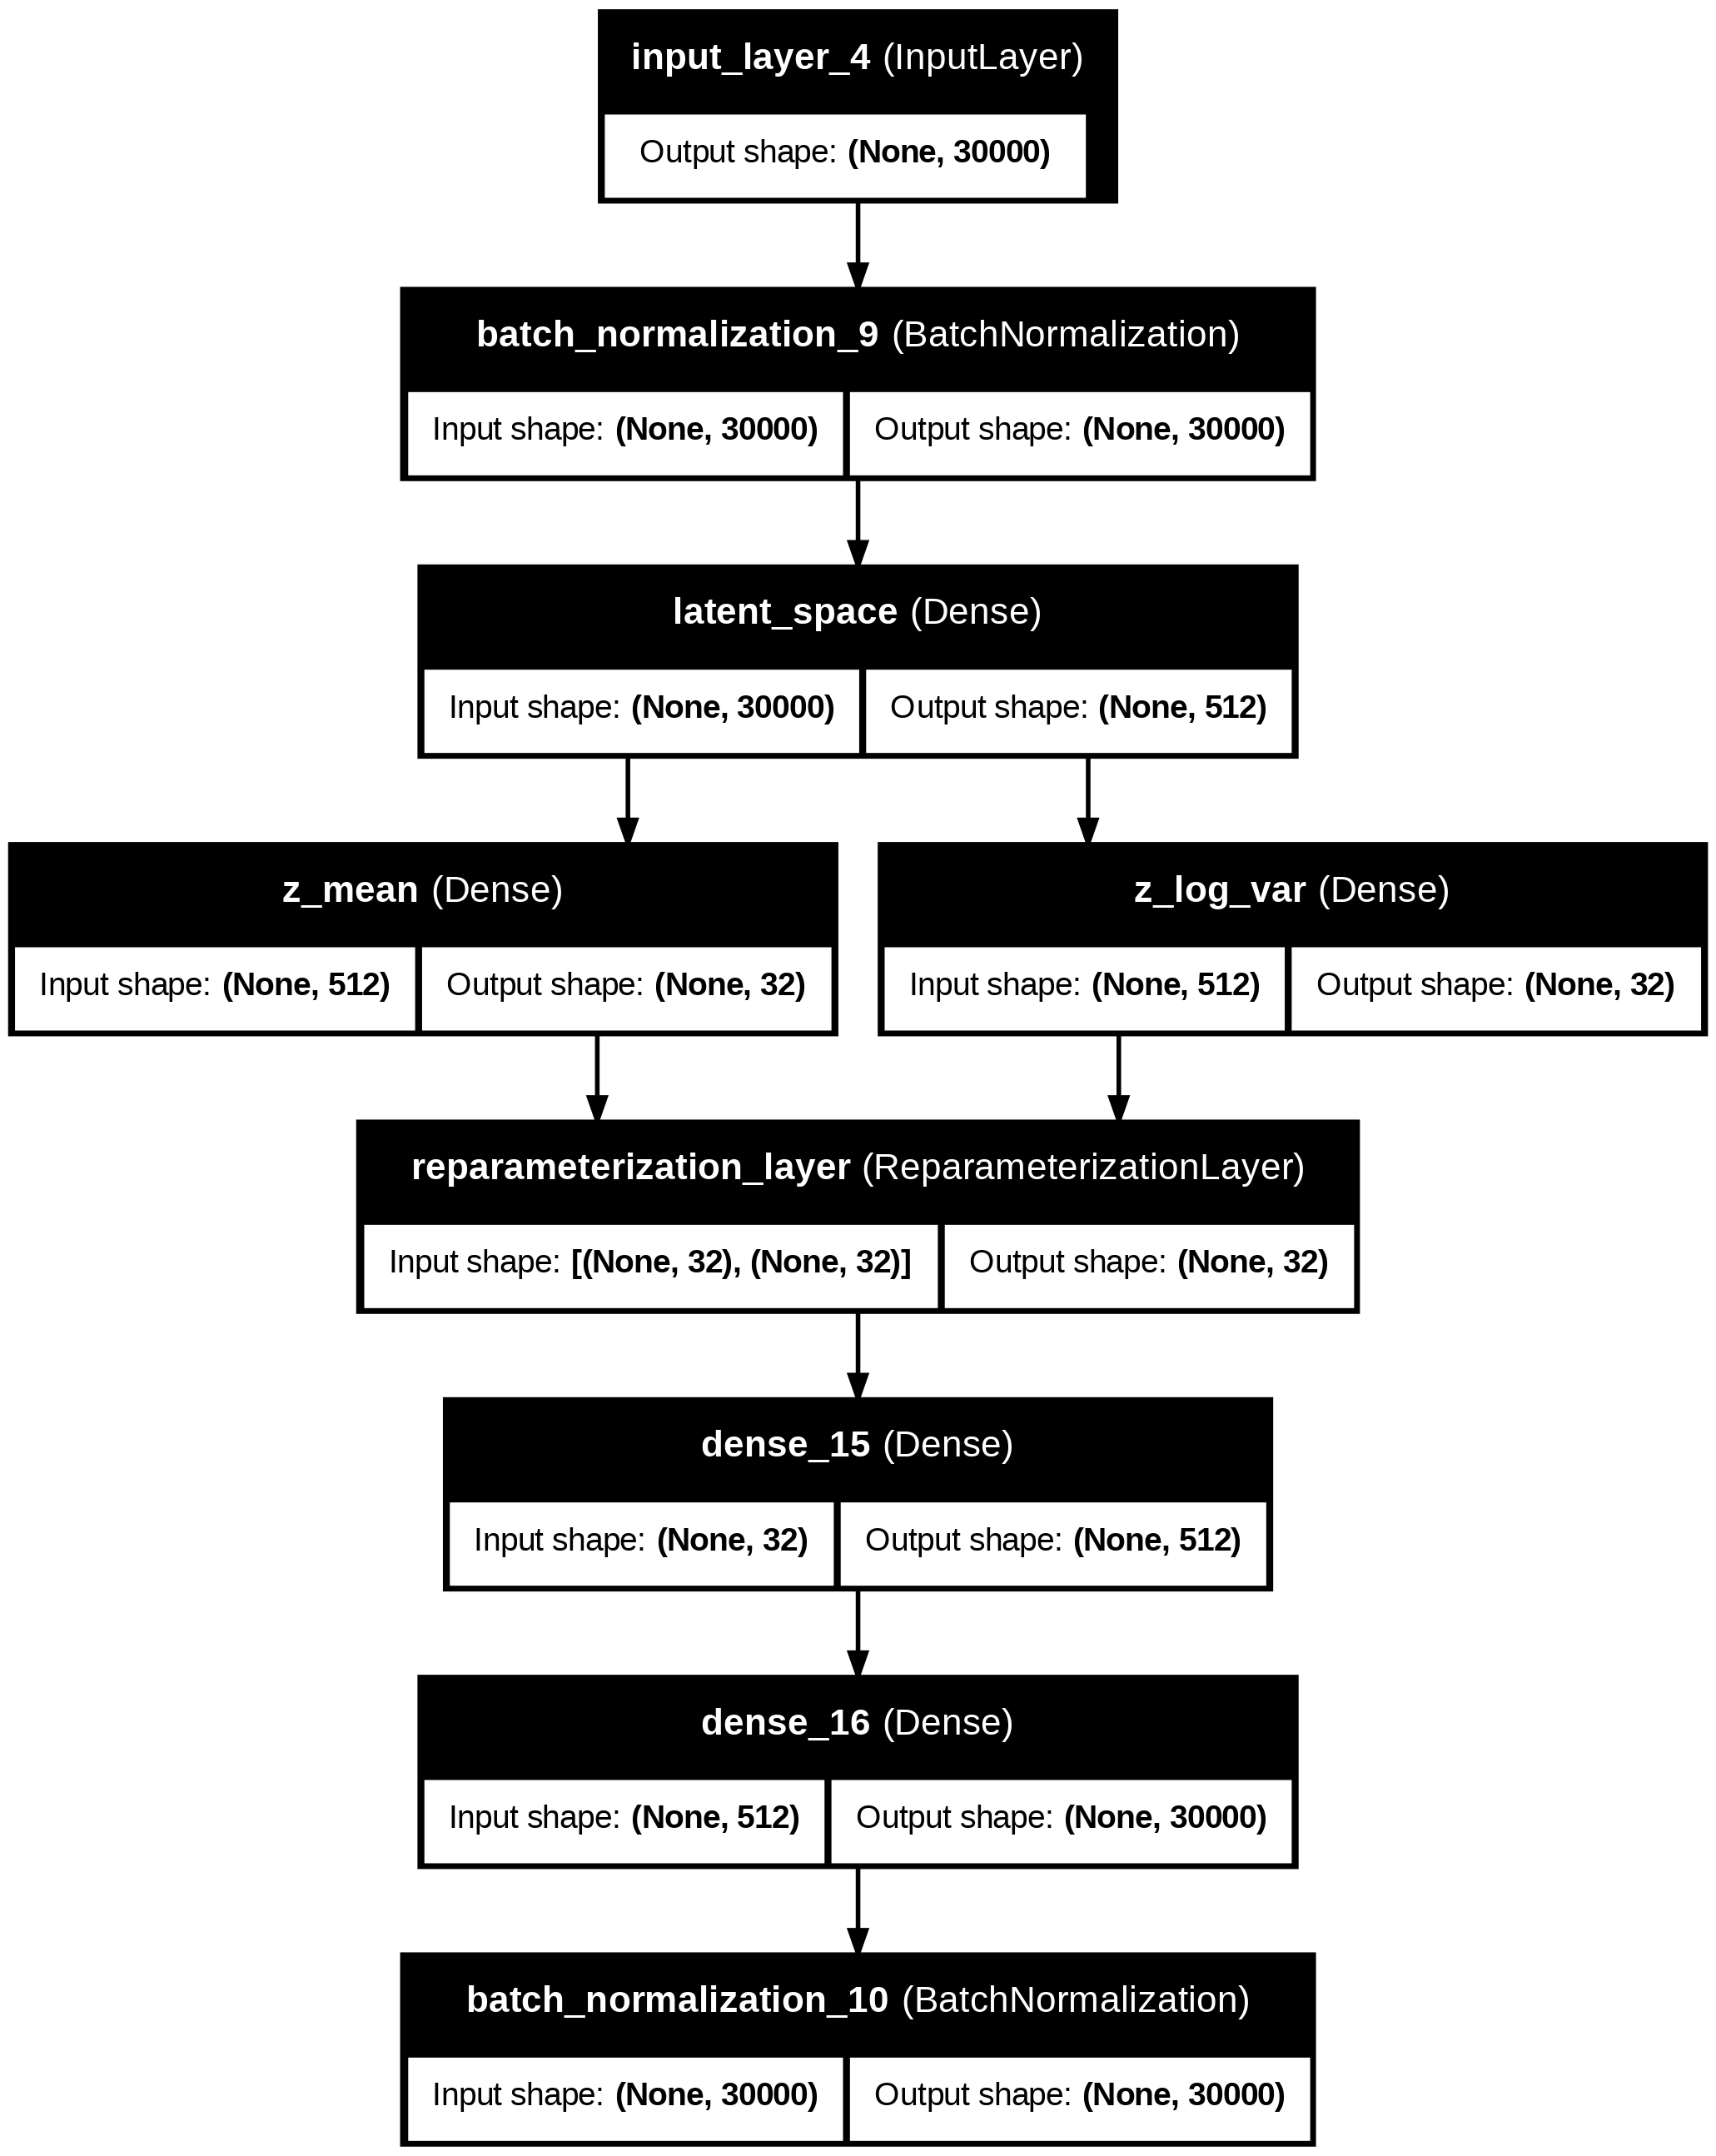

In [43]:
model_plotting = build_model()
tf.keras.utils.plot_model(model_plotting, to_file = 'plot.png', show_shapes = True, show_layer_names = True)

In [44]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE))
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'vae_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
optimizers = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(batch_size = BATCH_SIZE)

In [46]:
import builtins

In [47]:
loss_history = []
kl_dv_history = []

num_batches = x_train.shape[0] // BATCH_SIZE

for epoch in range(25):
  for x in dataset:
    x = tf.reshape(x, [-1, IMAGE_SIZE])

    with tf.GradientTape() as tape:
      x_reconstruction_logits, mu, log_var = model(x)

      reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = x, logits = x_reconstruction_logits)

      reconstruction_loss = tf.reduce_sum(reconstruction_loss / BATCH_SIZE)

      kl_div = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis = -1)
      kl_div = tf.reduce_mean(kl_div)

      loss = tf.reduce_mean(reconstruction_loss + kl_div)

    gradients = tape.gradient(loss, model.trainable_variables)

    for g in gradients:
      tf.clip_by_norm(g, 15)

    optimizers.apply_gradients(builtins.zip(gradients, model.trainable_variables))

  loss_history.append(loss)
  kl_dv_history.append(kl_div)
  print(f"Epoch: [{epoch+1}/25] | Reconstruction Loss: {float(reconstruction_loss):.2f} | KLDiv: {float(kl_div):.2f} | Loss: {float(loss):.2f}")

Epoch: [1/25] | Reconstruction Loss: 6006.06 | KLDiv: 776.54 | Loss: 6782.60
Epoch: [2/25] | Reconstruction Loss: 5973.97 | KLDiv: 662.76 | Loss: 6636.72
Epoch: [3/25] | Reconstruction Loss: 3891.01 | KLDiv: 836.10 | Loss: 4727.11
Epoch: [4/25] | Reconstruction Loss: 5000.97 | KLDiv: 297.94 | Loss: 5298.91
Epoch: [5/25] | Reconstruction Loss: 3179.11 | KLDiv: 372.59 | Loss: 3551.70
Epoch: [6/25] | Reconstruction Loss: 4912.62 | KLDiv: 354.66 | Loss: 5267.28
Epoch: [7/25] | Reconstruction Loss: 4428.05 | KLDiv: 278.40 | Loss: 4706.45
Epoch: [8/25] | Reconstruction Loss: 2602.38 | KLDiv: 275.07 | Loss: 2877.45
Epoch: [9/25] | Reconstruction Loss: 1815.37 | KLDiv: 300.03 | Loss: 2115.40
Epoch: [10/25] | Reconstruction Loss: 3239.19 | KLDiv: 270.66 | Loss: 3509.85
Epoch: [11/25] | Reconstruction Loss: 2628.98 | KLDiv: 324.81 | Loss: 2953.79
Epoch: [12/25] | Reconstruction Loss: 3008.21 | KLDiv: 350.25 | Loss: 3358.46
Epoch: [13/25] | Reconstruction Loss: 2519.02 | KLDiv: 261.80 | Loss: 278

In [48]:
def get_out_from_z(z):
  out = model.decode(z)
  out = tf.reshape(out, (-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]))
  return out

In [50]:
import matplotlib.pyplot as plt

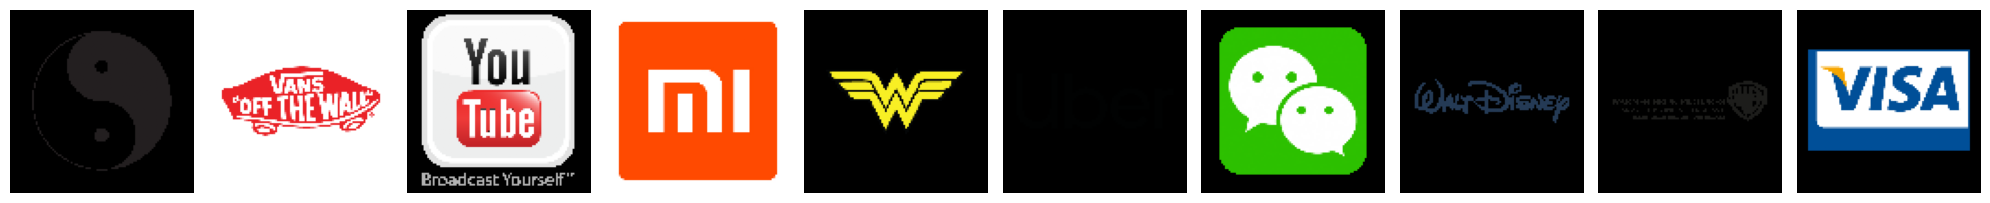

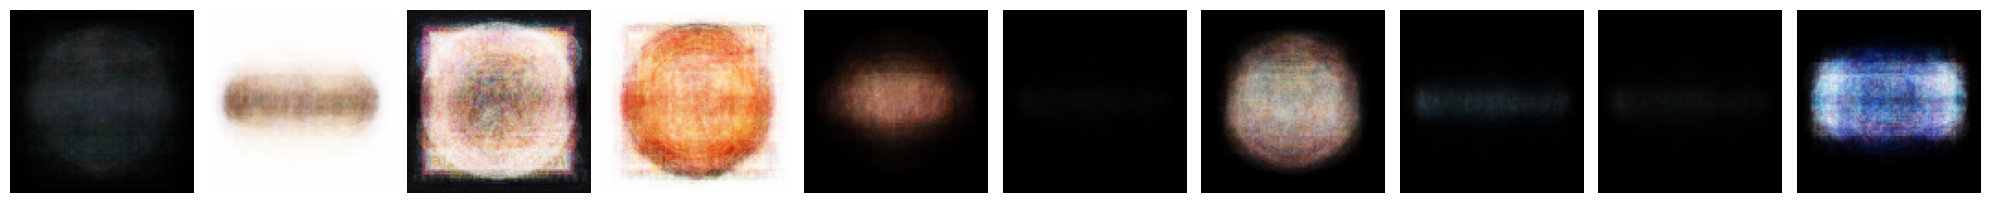

In [51]:
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)
out = get_out_from_z(z)

number = 10
plt.figure(figsize=(20, 8))
for idx in range(number):
  ax = plt.subplot(2, number, idx + 1)
  plt.imshow(x_test[idx].reshape(IMAGE_ORIGINAL_SHAPE), cmap = 'gray')
  plt.axis(False)

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 8))
for idx in range(number):
  ax = plt.subplot(2, number, idx + 1)
  plt.imshow(out[idx], cmap = 'gray')
  plt.axis(False)

plt.tight_layout()
plt.show()